features voor spoken

In [80]:
## packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import stats

In [115]:
## Import file "spoken"
spoken_array = np.load('spoken_train.npy', allow_pickle=True)

match_train = np.load('match_train.npy', allow_pickle=True)

written_train   = np.load("written_train.npy", allow_pickle=True).reshape(45000,28,28)
written_train = (written_train-255)/-255
written_train.shape

(45000, 28, 28)

voorselectie maken van de data

In [116]:
target = []
indexes_true = []
indexes_false = []
                       
for i, j in enumerate(match_train):
    if j == True:
        target.append(1)
        indexes_true.append(i)
    elif j == False:
        target.append(0)
        indexes_false.append(i)
        
false_included = indexes_false[:6000]
included_rows = indexes_true + false_included

In [117]:
spoken_array = spoken_array[included_rows]
match_train = match_train[included_rows]
written_train = written_train[included_rows]

Alle input even lang maken

In [118]:
lengths_spoken = np.empty(len(spoken_array))
for index, value in enumerate(spoken_array):
    lengths_spoken[index] = value.shape[0]

sorted_lengths = np.sort(lengths_spoken)
longest_length = sorted_lengths[-1]
print(longest_length)

padden_spoken = []

for i in spoken_array:
    if i.shape[0] < longest_length:
        pad_size = longest_length - i.shape[0]
        length = i.shape[1]
        pad_array = np.zeros((13,), dtype=np.int)
        x = np.tile(pad_array, (int(pad_size),1))
        i = np.concatenate((i, x), axis=0)
        padden_spoken.append(i)
    else:
        padden_spoken.append(i)

93.0


In [119]:
##gemiddelde lengte
round(lengths_spoken.mean())

40.0

In [120]:
spoken_train = np.array(padden_spoken).reshape(len(spoken_array),int(longest_length),13)

spoken_train.shape

(10539, 93, 13)

De data ziet er zo uit:

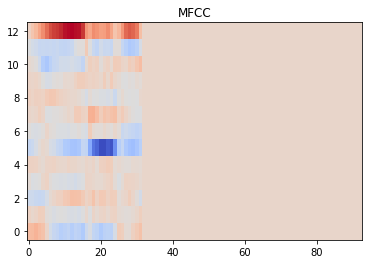

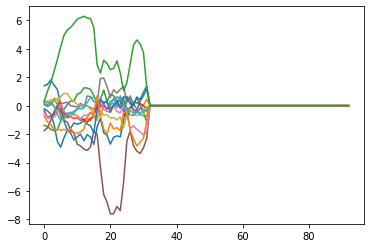

In [121]:
mfcc_feat = spoken_train[22]

ig, ax = plt.subplots()
mfcc_data= np.swapaxes(mfcc_feat, 0 ,1)
cax = ax.imshow(mfcc_data, interpolation='nearest', cmap=cm.coolwarm, origin='lower', aspect='auto')
ax.set_title('MFCC')
#Showing mfcc_data
plt.show()
#Showing mfcc_feat
plt.plot(mfcc_feat)
plt.show()

mean per feature (Z-score)

In [123]:
def features_mean_spoken1(signal):
    #Axis=1, is all channel arrays
    return np.mean(signal, axis=1)
    #..............................
    
def features_mean_spoken2(signal):
    #Axis=2, is last dimension, namely the time-wise arrays of which we wanna know the mean
    return np.mean(signal, axis=2)
    #..............................

In [124]:
mean_1 = features_mean_spoken1(spoken_train)
mean_2 = features_mean_spoken2(spoken_train)
print(mean_1.shape)
print(mean_2.shape)

(10539, 13)
(10539, 93)


In [125]:
def features(signal, functions):
#.........................................    
    return np.concatenate([ function(signal, axis=2) for function in functions ], axis=1)

summaries = [np.mean, np.min, np.max, np.std]

X_train0 = features(spoken_train, summaries)
print("Input shape {}".format(spoken_train.shape))
print("The resulting shape should be {}".format(
        (spoken_train.shape[0], spoken_train.shape[1]*len(summaries))))
print(X_train0.shape)

Input shape (10539, 93, 13)
The resulting shape should be (10539, 372)
(10539, 372)


features voor written

In [126]:
X_train1 = features(written_train, summaries)
print("Input shape {}".format(written_train.shape))
print("The resulting shape should be {}".format(
        (written_train.shape[0], written_train.shape[1]*len(summaries))))
print(X_train1.shape)

Input shape (10539, 28, 28)
The resulting shape should be (10539, 112)
(10539, 112)


In [127]:
X_train = np.concatenate([X_train1, X_train0], axis = 1)
X_train.shape

(10539, 484)

In [128]:
summaries = [np.mean, np.min, np.max, np.std]

X_train0 = features(spoken_train, summaries)
X_train1 = features(written_train, summaries)
X_train2 = np.concatenate([X_train1, X_train0], axis = 1)

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train2, match_train, test_size = 0.2)

In [129]:
# ...................................................
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score

#X_train = features_mean(train_signal)
#X_valid = features_mean(valid_signal)
print("Passes\t Acc")
for passes in [5, 10, 20, 40]:
    model = Perceptron(random_state=666, n_iter=passes)
    model.fit(X_train, y_train)
    acc = accuracy_score(y_val, model.predict(X_val))
    print("{}\t {}".format(passes, acc))

Passes	 Acc
5	 0.5574003795066413
10	 0.5574003795066413


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


20	 0.5360531309297912


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


40	 0.45920303605313095


In [130]:
def best(X, y, X_val, y_val):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X_val = scaler.transform(X_val)
    acc = []
    for passes in [5, 10, 20, 40]:
        model = Perceptron(random_state=666, n_iter = passes)
        model.fit(X, y)
        acc.append(accuracy_score(y_val, model.predict(X_val)))
    return np.max(acc)

from sklearn.preprocessing import StandardScaler

#X_valid = features(valid_signal, summaries)
acc = best(X_train, y_train, X_val, y_val)
print("All {}".format(acc))

#for i in range(len(summaries)):
#    fs = summaries[:i] + summaries[i+1:]
#    X_train0 = features(spoken_train, fs)
#    X_train1 = features(written_train, fs)
#    X_train = np.concatenate([X_train1, X_train0], axis = 1)
#    X_valid = features(valid_signal, fs)
#    this = best(X_train, y_train, X_valid, y_valid)
#    print("{} {}".format(summaries[i].__name__, this))
#


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be r

All 0.5284629981024668


In [131]:
summaries = [np.mean]

X_train0 = features(spoken_train, summaries)
X_train1 = features(written_train, summaries)
X_train2 = np.concatenate([X_train1, X_train0], axis = 1)

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train2, match_train, test_size = 0.2)

In [132]:
X_train.shape

(8431, 121)

In [133]:
from sklearn.metrics.pairwise import paired_cosine_distances

def cosine_feat(train_text, test_text, split):
    train_sim = []
    test_sim = []
    for i in range(0,len(train_text)):
        distance1, path = fastdtw(train_text[i,:split], train_text[i,split:], dist=euclidean)
        train_sim.append(distance1)
    for j in range(0,len(test_text)):
        distance2, path = fastdtw(test_text[j,:split], test_text[j,split:], dist=euclidean)
        test_sim.append(distance2)
    return (train_sim, test_sim)

X_train, X_test = cosine_feat(X_train, X_val, X_train1.shape[1])

X_train1 = np.array(X_train).reshape((-1,1))
X_test1 = np.array(X_test).reshape((-1,1))

print("algo setting accuracy")
for passes in [5, 10, 20, 40,100]:
    model = Perceptron(n_iter=passes, random_state=666)
    model.fit(X_train1, y_train)
    print("perceptron passes={} {}".format(passes, accuracy_score(y_val, model.predict(X_test1))))

algo setting accuracy
perceptron passes=5 0.5735294117647058
perceptron passes=10 0.5735294117647058
perceptron passes=20 0.4264705882352941
perceptron passes=40 0.5735294117647058
perceptron passes=100 0.5735294117647058


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be r